In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('../DATA/RSCCASN.csv',parse_dates=True,index_col='DATE')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [5]:
df.columns =['Sales']

<AxesSubplot:xlabel='DATE'>

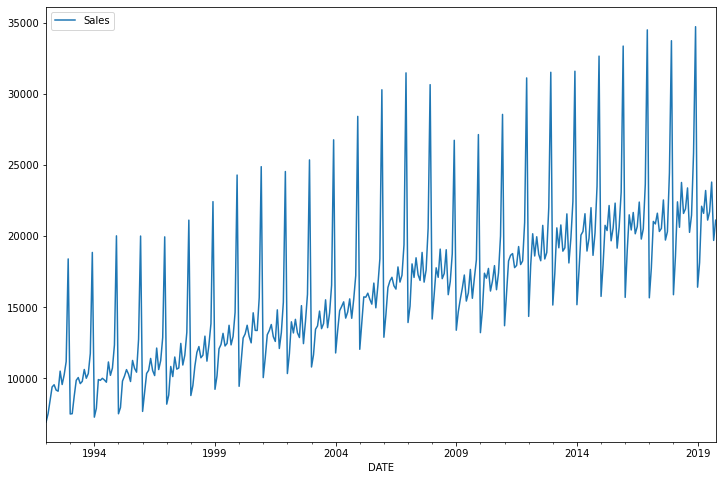

In [6]:
df.plot(figsize=(12,8))

In [10]:
len(df)-18

316

In [12]:
test_size = 18
test_ind = len(df)-test_size

In [13]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
scaler.fit(train)

MinMaxScaler()

In [17]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)

In [20]:
X,y=generator[0]

In [21]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [22]:
y

array([[0.02047633]])

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
n_features =1

In [38]:
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [37]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [28]:
val_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [39]:
model.fit_generator(generator,epochs=20,validation_data=val_generator,callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0228 - val_loss: 0.0031
Epoch 2/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0182 - val_loss: 0.0038
Epoch 3/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0105 - val_loss: 7.6229e-04
Epoch 4/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0140
Epoch 5/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0131
Epoch 6/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 5.6001e-04
Epoch 7/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 8/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 6.2988e-04
Epoch 9/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0016


In [40]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

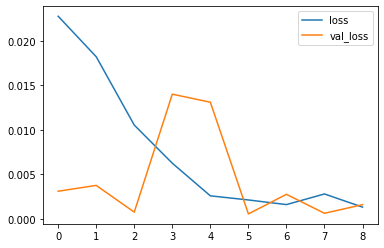

In [41]:
losses.plot()

In [42]:
test_pred = []
#it was already implemented above but i just wanted to redo it again so that i can understand it better.
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    #predicts the 51th item based on the 50 in the current_batch.
    current_pred = model.predict(current_batch)[0]
    #the prediction is then appened into the test_pred for saving
    test_pred.append(current_pred)
    #then the current batch is updated to add the new prediction as its 50th item and drop the first item to stay at 50 items.
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [44]:
true_pred = scaler.inverse_transform(test_pred)

In [45]:
test['predictions'] =true_pred

<ipython-input-45-0d4fdd3328fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] =true_pred


In [46]:
test

,Sales,predictions
DATE,,
2018-05-01,23764,22219.945693
2018-06-01,21589,20891.058794
2018-07-01,21919,21173.083592
2018-08-01,23381,23271.430964
2018-09-01,20260,20371.510483
2018-10-01,21473,21170.996927
2018-11-01,25831,25846.022199
2018-12-01,34706,37134.516914
2019-01-01,16410,15729.840653


<AxesSubplot:xlabel='DATE'>

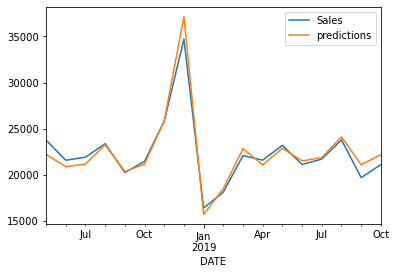

In [47]:
test.plot()

In [112]:
full_scaler = MinMaxScaler()
full_scaled_data = full_scaler.fit_transform(df)

array([[0.        ],
       [0.02110343],
       [0.05535148],
       [0.08869922],
       [0.09435321],
       [0.08081245],
       [0.07796744],
       [0.12874532],
       [0.0948934 ],
       [0.11941804],
       [0.15301786],
       [0.41259723],
       [0.02031115],
       [0.02110343],
       [0.06583117],
       [0.10548113],
       [0.11253961],
       [0.09712619],
       [0.1028522 ],
       [0.13288678],
       [0.11073898],
       [0.1227312 ],
       [0.17365313],
       [0.42901901],
       [0.01231634],
       [0.03471622],
       [0.10742581],
       [0.10555315],
       [0.11059493],
       [0.10641746],
       [0.10072746],
       [0.15193748],
       [0.11808557],
       [0.13656007],
       [0.19504466],
       [0.47097378],
       [0.02088735],
       [0.03684097],
       [0.10360847],
       [0.11632094],
       [0.13259867],
       [0.12111063],
       [0.10249208],
       [0.15579084],
       [0.13583982],
       [0.12608038],
       [0.20934169],
       [0.470

In [114]:
length = 12
generator = TimeseriesGenerator(full_scaled_data,full_scaled_data,length=length,batch_size=1)

In [104]:
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [115]:
model.fit_generator(generator,epochs=9)

Epoch 1/9
322/322 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 2/9
322/322 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 3/9
322/322 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 4/9
322/322 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 5/9
322/322 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 6/9
322/322 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 7/9
322/322 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 8/9
322/322 [==============================] - 1s 2ms/step - loss: 8.9367e-04
Epoch 9/9
322/322 [==============================] - 1s 2ms/step - loss: 0.0017


In [148]:
forecast = []
#adding this is for the purpose of maimaintaining the limit of prediciton we will give.
periods = 12
#it was already implemented above but i just wanted to redo it again so that i can understand it better.
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(periods):
    #predicts the 51th item based on the 50 in the current_batch.
    current_pred = model.predict(current_batch)[0]
    #the prediction is then appened into the test_pred for saving
    forecast.append(current_pred)
    #then the current batch is updated to add the new prediction as its 50th item and drop the first item to stay at 50 items.
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [149]:
forecast = scaler.inverse_transform(forecast)


In [128]:
forecast_ind = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [121]:
forecast_ind

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [135]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_ind,columns=['Forecast'])

In [136]:
forecast_df

,Forecast
2019-11-01,23081.647561
2019-12-01,21778.676963
2020-01-01,22030.197815
2020-02-01,24138.761065
2020-03-01,21271.565365
2020-04-01,21860.659120
2020-05-01,26263.468179
2020-06-01,37123.444964
2020-07-01,16949.350659
2020-08-01,19835.568444


<AxesSubplot:xlabel='DATE'>

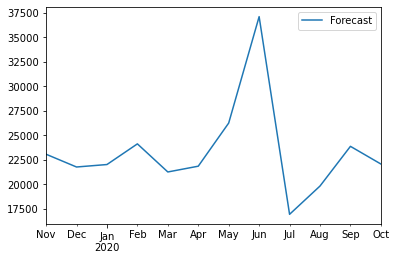

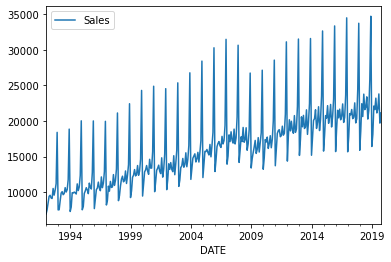

In [137]:
forecast_df.plot()
df.plot()

<AxesSubplot:xlabel='DATE'>

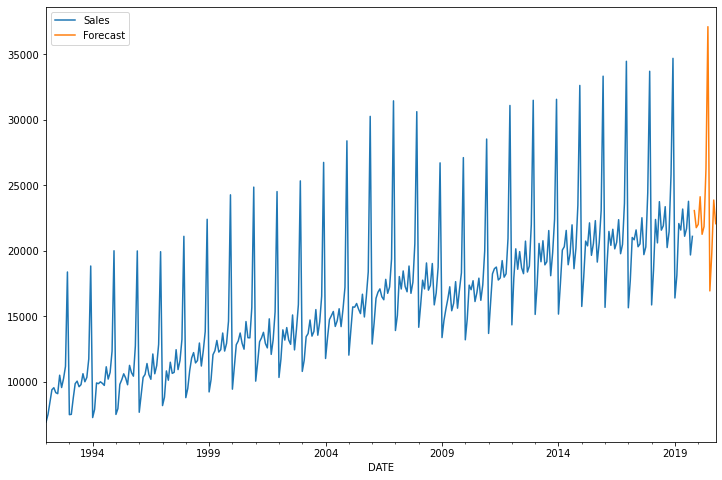

In [151]:
ax = df.plot()
forecast_df.plot(ax=ax,figsize=(12,8))
#plt.xlim('2018-01-01','2020-12-01')

In [152]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
